In [33]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

### Data fetching for clustering
We choose 2011-01-01 to 2021-12-31 daily close price data for clustering.

In [2]:
'''
start_date = "2009-01-01"
end_date = "2023-12-31"

data = utils.fetch_s_and_p_500_data(start_date, end_date)
data.to_csv("training_data.csv")
'''

'\nstart_date = "2009-01-01"\nend_date = "2023-12-31"\n\ndata = utils.fetch_s_and_p_500_data(start_date, end_date)\ndata.to_csv("training_data.csv")\n'

## Data preprocessing

In [3]:
training_data = pd.read_csv('training_data.csv', index_col=0)

In [4]:
training_data.head()

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-02 00:00:00,11.616595,3.241071,NaN,NaN,25.698088,7.663333,33.669998,23.020000,19.67,29.190001,...,66.860924,31.889999,47.419998,18.840000,81.639999,NaN,23.005032,40.543690,21.030001,NaN
2009-01-05 00:00:00,12.010014,3.377857,NaN,NaN,25.256672,7.597778,33.820000,23.129999,19.57,29.080000,...,65.933777,31.930000,52.299999,18.660000,81.629997,NaN,23.630482,39.708736,20.740000,NaN
2009-01-06 00:00:00,12.968526,3.322143,NaN,NaN,24.431416,7.583333,33.400002,24.219999,20.52,28.290001,...,68.715233,32.029999,55.279999,18.420000,80.300003,NaN,23.587347,40.446602,21.260000,NaN
2009-01-07 00:00:00,13.040057,3.250357,NaN,NaN,24.297071,7.461111,33.779999,24.230000,19.75,28.340000,...,68.609268,31.260000,47.230000,18.230000,78.250000,NaN,22.746225,39.135921,21.280001,NaN
2009-01-08 00:00:00,13.125894,3.310714,NaN,NaN,24.565760,7.586667,33.439999,24.290001,19.77,27.760000,...,69.218544,32.000000,46.450001,18.469999,79.089996,NaN,22.638390,40.184467,20.629999,NaN


In [5]:
training_data.shape

(3774, 503)

### Data cleaning

In [6]:
# Columns with more than 10% missing values are removed and other missing values are filled by both forward and backward filling
training_data = utils.fill_missing_val(training_data)

In [7]:
# Check whether there are still missing values
training_data.isnull().values.any()

False

In [8]:
training_data.index = pd.to_datetime(training_data.index)

In [9]:
# Now 'clustering_data' contains data from 2009-01-01 to 2017-12-31 for clustering 
# and 'criteria_data' contains data from 2018-01-01 to 2021-12-31 for applying criteria to select promising stocks
training_end_date = "2017-12-31"
split_1 = "2018-01-01"
split_2 = "2021-12-31"
split_3 = "2022-01-01"
# Split the data into 'clustering_data' and 'criteria_data'
clustering_data = training_data[:training_end_date]
criteria_data = training_data[split_1:split_2]
test_data = training_data[split_3:]

criteria_data.head()

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,67.599998,43.064999,58.790001,29.433332,153.839996,177.699997,90.279999,40.090000,115.989998,107.120003,...,20.752592,99.500000,146.990005,35.299999,164.300003,47.810001,85.029999,81.599998,120.446602,103.709999
2018-01-03,69.320000,43.057499,58.919998,29.459999,154.550003,181.039993,91.400002,39.779999,117.250000,109.379997,...,20.580742,99.620003,149.740005,35.610001,162.520004,47.490002,86.699997,81.529999,121.281555,105.769997
2018-01-04,68.800003,43.257500,58.820000,29.570000,156.380005,183.220001,91.300003,40.450001,118.370003,112.070000,...,20.663704,99.589996,151.259995,35.320000,163.399994,47.119999,86.820000,82.360001,121.106796,107.860001
2018-01-05,69.900002,43.750000,58.990002,29.453333,157.669998,185.339996,91.669998,40.180000,118.300003,110.839996,...,20.577778,100.839996,152.229996,35.270000,164.490005,46.790001,86.750000,82.839996,122.310677,109.540001
2018-01-08,70.050003,43.587502,58.820000,29.456667,158.929993,185.039993,91.830002,40.090000,117.940002,111.419998,...,20.474073,101.410004,151.410004,35.500000,162.300003,47.139999,87.139999,82.980003,122.543686,110.629997


In [12]:
# Calculate annualized returns and volatility for each asset
rv_data = pd.DataFrame({
    'Returns': clustering_data.pct_change().mean() * 252,
    'Volatility': clustering_data.pct_change().std() * np.sqrt(252)
})
rv_data.head()

,Returns,Volatility
A,0.240500,0.301274
AAPL,0.320832,0.263617
ABT,0.106965,0.190115
ACGL,0.170602,0.188128
ACN,0.194225,0.225740


In [14]:
scaler = StandardScaler()
rescaled_rv_data = pd.DataFrame(
    scaler.fit_transform(rv_data),
    columns=rv_data.columns,
    index=rv_data.index
)

'''
from scipy.stats import zscore

# Calculate Z-scores for all columns
z_scores = rescaled_rv_data.apply(zscore)

# Filter out rows where any feature has a Z-score > 3 to remove outliers
rescaled_rv_data = rescaled_rv_data[(z_scores < 3).all(axis=1)]
'''
rescaled_rv_data.head()

,Returns,Volatility
A,0.465457,0.026897
AAPL,1.339344,-0.363395
ABT,-0.987197,-1.125189
ACGL,-0.294928,-1.145778
ACN,-0.037940,-0.755957


## K-means clustering

/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Use

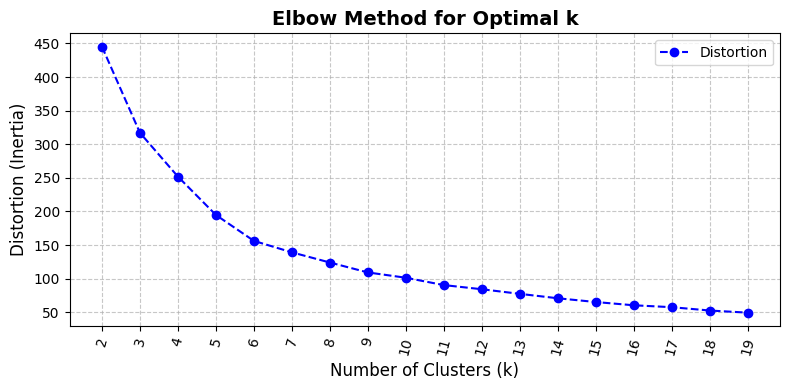

In [16]:
distortions = []
max_clusters = 20

# Compute distortions for different cluster sizes
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(rescaled_rv_data)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, max_clusters), distortions, marker='o', linestyle='--', color='b', label='Distortion')
plt.title('Elbow Method for Optimal k', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Distortion (Inertia)', fontsize=12)
plt.xticks(range(2, max_clusters), fontsize=10, rotation=75)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()  
plt.show()

#### We can determine the optimal number of clusters using the Silhouette score

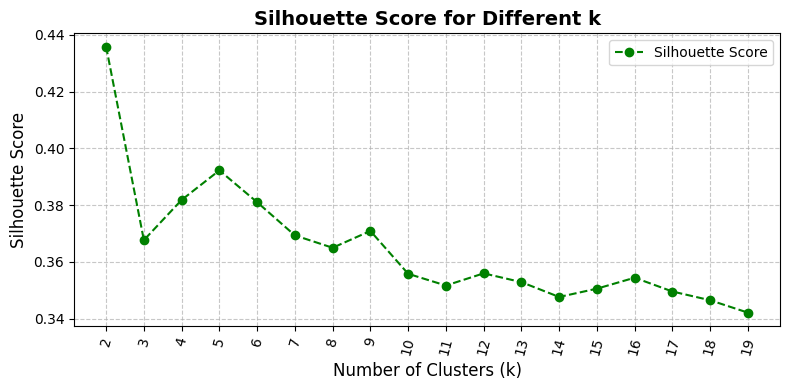

In [17]:
silhouette_score = []
max_loop = 20
# Compute silhouette scores for different cluster sizes
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=10) 
    kmeans.fit(rescaled_rv_data)
    silhouette_score.append(metrics.silhouette_score(rescaled_rv_data, kmeans.labels_, random_state=10))

fig = plt.figure(figsize=(8, 4))  
plt.plot(range(2, max_loop), silhouette_score, marker='o', linestyle='--', color='g', label='Silhouette Score')
plt.title('Silhouette Score for Different k', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(range(2, max_loop), fontsize=10, rotation=75)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()  
plt.show()

#### Combining the results from both elbow and Silhouette score, we shall choose number of clusters to be 5 and fit with k-means

/Users/yatfanlau/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/5g/p16z87ld7f36bnhsyhh0tq4r0000gn/T/ipykernel_79727/2869967334.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "^g" (-> color='g'). The keyword argument will take precedence.
  ax.plot(


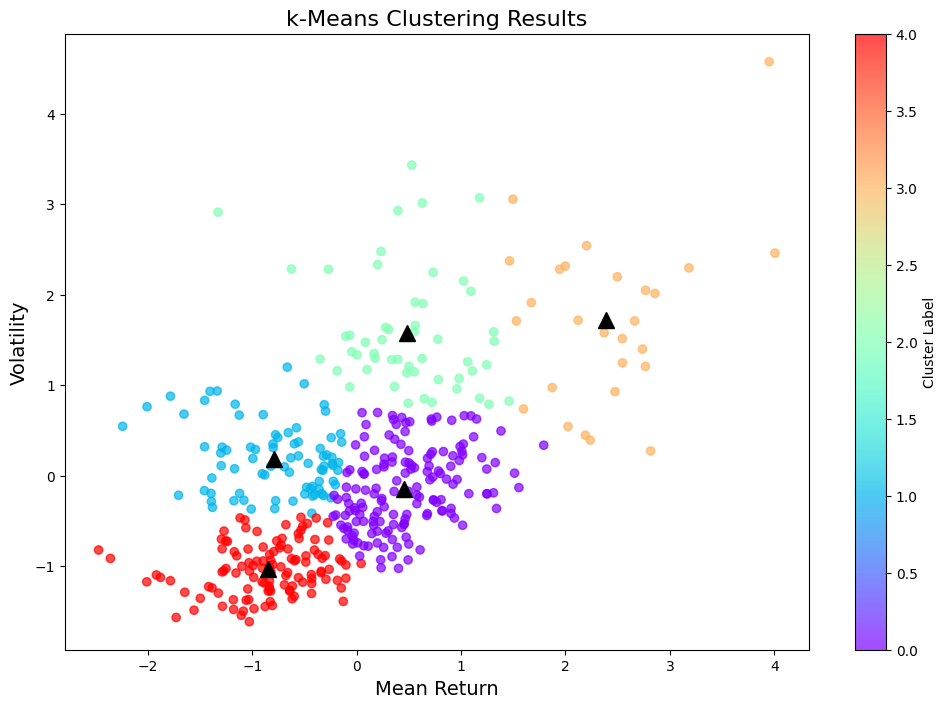

In [18]:
n_clu = 5
k_means = cluster.KMeans(
    n_clusters=n_clu, 
    init='k-means++', 
    max_iter=500,  
    random_state=42
)
k_means.fit(rescaled_rv_data)
target_labels = k_means.predict(rescaled_rv_data)

# Extract centroids from the k-means model
centroids = k_means.cluster_centers_
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot of the clusters
scatter = ax.scatter(
    rescaled_rv_data.iloc[:, 0], rescaled_rv_data.iloc[:, 1], 
    c=k_means.labels_, cmap="rainbow", 
    label=rescaled_rv_data.index, alpha=0.7
)

# Add colorbar for the clusters
plt.colorbar(scatter, label='Cluster Label')

# Plot the centroids
ax.plot(
    centroids[:, 0], centroids[:, 1], 
    '^g',color='black', markersize=11, label='Centroids'
)
ax.set_title('k-Means Clustering Results', fontsize=16)
ax.set_xlabel('Mean Return', fontsize=14)
ax.set_ylabel('Volatility', fontsize=14)
plt.show()

In [21]:
from collections import defaultdict

# Create a dictionary to store stocks within each cluster
clustered_stocks = defaultdict(list)

# Iterate over the labels and the corresponding indices
for stock_index, cluster_label in zip(rescaled_rv_data.index, k_means.labels_):
    clustered_stocks[cluster_label].append(stock_index)

# Convert defaultdict to a regular dictionary if needed
clustered_stocks = dict(clustered_stocks)

# Print the clusters and their corresponding stocks
for cluster, stocks in clustered_stocks.items():
    print(f"Cluster {cluster}: {stocks}")

Cluster 0: ['A', 'AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'ALB', 'AMAT', 'AME', 'AMP', 'AMT', 'ANSS', 'AOS', 'APH', 'AVGO', 'AXP', 'BA', 'BIIB', 'BLK', 'BR', 'BWA', 'CCI', 'CDNS', 'CHTR', 'CI', 'CMCSA', 'CMG', 'CMI', 'COO', 'COR', 'CPRT', 'CRL', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DD', 'DE', 'DFS', 'DG', 'DIS', 'DLR', 'DLTR', 'DOV', 'DRI', 'EA', 'EBAY', 'EFX', 'EL', 'ELV', 'EMN', 'EQIX', 'EW', 'EXR', 'F', 'FDS', 'FDX', 'FI', 'FICO', 'FIS', 'FMC', 'GL', 'GNRC', 'GOOG', 'GOOGL', 'GPN', 'HD', 'HON', 'HUBB', 'HUM', 'ICE', 'IDXX', 'IEX', 'IFF', 'INTU', 'IPG', 'ISRG', 'IT', 'ITW', 'JBHT', 'JKHY', 'JPM', 'KDP', 'KLAC', 'KMX', 'LHX', 'LII', 'LKQ', 'LOW', 'LRCX', 'LUV', 'LYB', 'MA', 'MAR', 'MCHP', 'MCK', 'MCO', 'MHK', 'MNST', 'MPWR', 'MSCI', 'MSFT', 'MSI', 'MTCH', 'MTD', 'NDSN', 'NI', 'NKE', 'NOC', 'NTAP', 'NVR', 'ODFL', 'OKE', 'ORLY', 'PH', 'PKG', 'POOL', 'PPG', 'PTC', 'RJF', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RVTY', 'SBAC', 'SBUX', 'SHW', 'SNA', 'SPG', 'SPGI', 'STE', 'STZ', 'SWK', 'TDG', 'TDY', 'T

Now the stocks are successfully grouped into different clusters. We then need to further select promising stock pairs within each cluster for pair trading. 

In [22]:
potential_pairs = {}

for label in clustered_stocks:
    cluster = clustered_stocks[label]
    print(f"Processing cluster {label} with {len(cluster)} stocks")
    pairs = utils.find_cointegrated_pairs(cluster, criteria_data)  # pairs.type is a list of dict
    print(f"{len(pairs)} pairs are found in cluster {label}")
    potential_pairs[label] = pairs


Processing cluster 0 with 158 stocks
886 pairs are found in cluster 0
Processing cluster 4 with 117 stocks
562 pairs are found in cluster 4
Processing cluster 1 with 80 stocks
120 pairs are found in cluster 1
Processing cluster 2 with 52 stocks
50 pairs are found in cluster 2
Processing cluster 3 with 27 stocks
14 pairs are found in cluster 3


In [31]:
#For exmaple
potential_pairs[4][0]['pair']

'ABT'

## Strategy implementation

('CAH', 'DUK') 2.0957657190460823


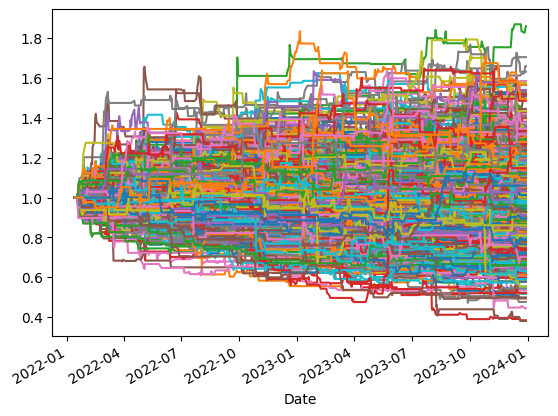

In [34]:
result = {}

for label in potential_pairs:
    for i in range(len(potential_pairs[label])):
        S1 = potential_pairs[label][i]['pair'][0]
        S2 = potential_pairs[label][i]['pair'][1]
        X = test_data[S1]
        Y = test_data[S2]
        X_with_constant = sm.add_constant(X)
        model = OLS(Y, X_with_constant).fit()
        spread = Y - model.predict()
        window_size = 10
        spread_mean = spread.rolling(window=window_size).mean()
        spread_std = spread.rolling(window=window_size).std()
        zscore = (spread - spread_mean) / spread_std
        # remove initial days with NA
        first_valid_idx = zscore.first_valid_index()
        zscore = zscore[first_valid_idx:]
        # set the threshold values for entry and exit signals
        entry_threshold = 2.0
        exit_threshold = 1.0
        # inítialize the daily positions to be zeros
        stock1_position = pd.Series(data=0, index=zscore.index)
        stock2_position = pd.Series(data=0, index=zscore.index)
        # generate daily entry and exit signals for each stock
        for i in range(1, len(zscore)):
            # zscore<-2 and no existing long position for stock 1
            if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
                stock1_position[i] = 1 # long stock 1
                stock2_position[i] = -1 # short stock 2
            # zscore>2 and no existing short position for stock 2
            elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
                stock1_position[i] = -1 # short stock 1
                stock2_position[i] = 1 # long stock 2
            # -1<zscore}<
            elif abs(zscore[i]) < exit_threshold:
                    stock1_position[i] = 0 # exit existing position
                    stock2_position[i] = 0
                # -2<zscore<-1 or 1<zscore<2
            else:
                stock1_position[i] = stock1_position[i-1] # maintain existing position
                stock2_position[i] = stock2_position[i-1]
                # Calculate the returns of each stock
        stock1_returns = (test_data[S1][first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
        stock2_returns = (test_data[S2][first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
        # calculate the total returns of the strategy
        total_returns = stock1_returns + stock2_returns
        cumulative_returns = (1 + total_returns).cumprod()

        final_cumulative_return = cumulative_returns.iloc[-1]

        # Set the risk-free rate (annual). For example, assume 3% per annum.
        # annual_risk_free_rate =   # 3% annual risk-free rate
        # daily_risk_free_rate = annual_risk_free_rate / 252  # Convert to daily rate

        # Calculate the average daily return and daily standard deviation of total returns
        average_daily_return = total_returns.mean()
        std_dev_daily_return = total_returns.std()

        # Annualize the average return and standard deviation
        average_annual_return = average_daily_return * 252
        annual_std_dev_return = std_dev_daily_return * np.sqrt(252)

        # Calculate the Sharpe Ratio
        #sharpe_ratio = (average_annual_return - annual_risk_free_rate) / annual_std_dev_return
        sharpe_ratio = (average_annual_return) / annual_std_dev_return
        result[(S1,S2)] = sharpe_ratio

max_stock_pair = max(result, key=result.get)
max_sharpe_ratio = max(result.values())

print(max_stock_pair, max_sharpe_ratio)

Now assume we invest $1000 at the beginning of the trading period and we plot how would the portfolio channge with time.

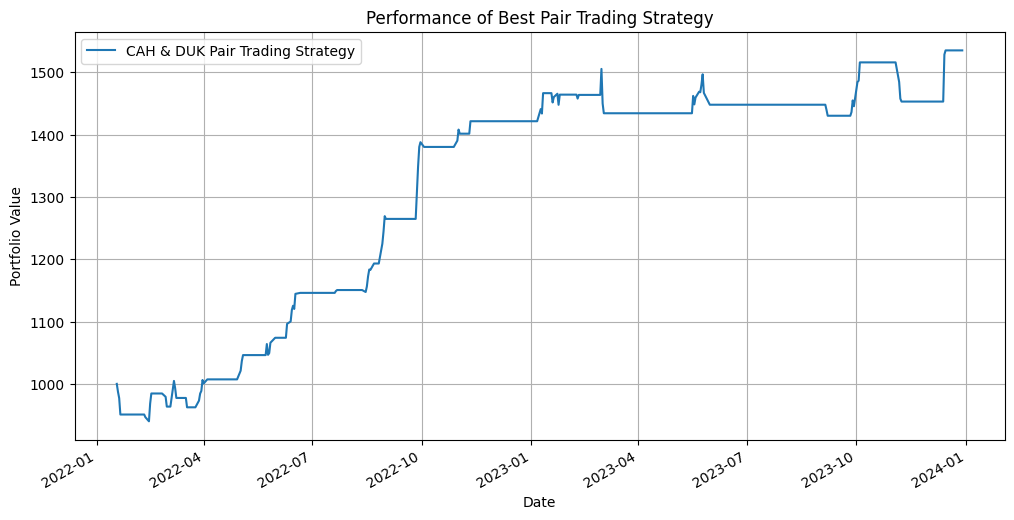

In [47]:
# Now, compute and plot the performance of the best pair
S1, S2 = max_stock_pair

# Repeat the same steps for the best pair
X = test_data[S1]
Y = test_data[S2]
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()

spread = Y - model.predict()
window_size = 10
spread_mean = spread.rolling(window=window_size).mean()
spread_std = spread.rolling(window=window_size).std()
zscore = (spread - spread_mean) / spread_std
first_valid_idx = zscore.first_valid_index()
zscore = zscore[first_valid_idx:]

entry_threshold = 2.0
exit_threshold = 1.0

stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)

for i in range(1, len(zscore)):
    if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = 1  # long stock 1
        stock2_position.iloc[i] = -1  # short stock 2
    elif zscore.iloc[i] > entry_threshold and stock1_position.iloc[i-1] == 0:
        stock1_position.iloc[i] = -1  # short stock 1
        stock2_position.iloc[i] = 1  # long stock 2
    elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0  # exit existing position
        stock2_position.iloc[i] = 0
    else:
        stock1_position.iloc[i] = stock1_position.iloc[i-1]
        stock2_position.iloc[i] = stock2_position.iloc[i-1]

stock1_returns = (test_data[S1][first_valid_idx:].pct_change() * stock1_position.shift(1))
stock2_returns = (test_data[S2][first_valid_idx:].pct_change() * stock2_position.shift(1))
total_returns = stock1_returns + stock2_returns
cumulative_returns = (1 + total_returns).cumprod()

initial_investment = 1000
portfolio_value = cumulative_returns * initial_investment

plt.figure(figsize=(12, 6))
portfolio_value.plot()
plt.title('Performance of Best Pair Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend([f'{S1} & {S2} Pair Trading Strategy'])
plt.grid(True)
plt.show()